In [2]:
import plotly.express as px
import plotly.graph_objects as go
#data imports
import pandas as pd
import numpy as np
import os
import pandas_datareader.data as web
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='YOUR_API_KEY',output_format='pandas', indexing_type='date')

In [62]:
def adjust(date, close, adj_close, in_col, rounding=4):
    '''
    If using forex or Crypto - Change the rounding accordingly!
    '''
    try:
        factor = adj_close / close
        return round(in_col * factor, rounding)
    except ZeroDivisionError:
        print('WARNING: DIRTY DATA >> {} Close: {} | Adj Close {} | in_col: {}'.format(date, close, adj_close, in_col))
        return 0

    
def getTickerData(ticker, start,end):
    df, meta_data = ts.get_daily_adjusted(ticker, outputsize='full')    
    df.sort_index(ascending=True, inplace = True)
    
    df = df[start:end]
    
    df['adj close'] = df['5. adjusted close']
    df['adj open'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['1. open'])
    df['adj high'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['2. high'])
    df['adj low'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['3. low'])    
    #calculate daily returns
    df['daily_return'] = df['adj close'].pct_change()
    # calculate cumluative return
    df['cumluative_return'] = np.exp(np.log1p(df['daily_return']).cumsum())
    
    return df[['adj open','adj close','adj high', 'adj low', 'daily_return', 'cumluative_return'  ]]


def getPtf(tickers, start, end):
    
    ptf = pd.DataFrame()
       
    for stock in tickers:
        df = getTickerData(stock, start, end)
        df.sort_index(ascending=True, inplace = True)
        df = pd.concat({stock: df}, names=['stock'])
        ptf =  pd.concat([df, ptf], axis=0)
        
    return ptf


def getPtfColumns(tickers, start, end):
    
    ptf = pd.DataFrame()
       
    for stock in tickers:
        df = getTickerData(stock, start, end)
        df.sort_index(ascending=True, inplace = True)
        df.columns = pd.MultiIndex.from_product([[stock], df.columns])
        ptf =  pd.concat([df, ptf], axis=1)
        
    return ptf

def getSpecificColumns(ptf, column, stocks):
    new_ptf = pd.DataFrame()

    for each in stocks:
        df = ptf.loc[:, each][[column]]
        df.columns = [each]
        new_ptf = pd.concat([df, new_ptf], axis=1)
    return new_ptf

def ptfPerformance(weights, ptf):
    returns = getSpecificColumns(ptf, 'daily_return', stocks)
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    weights_a = np.array(weights)
    
    ptf_return = np.sum(mean_returns*weights_a)*252
    
    ptf_std = np.sqrt(np.dot(weights_a.T, np.dot(cov_matrix, weights_a ))) * np.sqrt(252)
    
    return ptf_return, ptf_std


def randomWeights(n):
    k = np.random.rand(5)
    return k/sum(k)

In [4]:
stocks = ['BABA','SPOT','DIS','JPM','PYPL']

In [5]:
ptf = getPtf(stocks, '2020-01-01','2021-04-01')

In [9]:
ptf = getPtfColumns(stocks, '2020-01-01','2021-04-01')

In [10]:
ptf

PYPL                                             \
            adj open adj close  adj high   adj low daily_return   
date                                                              
2020-01-02  109.4700    110.75  111.2100  109.2750          NaN   
2020-01-03  109.4900    108.76  110.4200  108.7600    -0.017968   
2020-01-06  107.5700    110.17  110.2200  107.4400     0.012964   
2020-01-07  111.5000    109.67  111.5600  109.5300    -0.004538   
2020-01-08  110.4000    111.82  112.6400  109.8200     0.019604   
...              ...       ...       ...       ...          ...   
2021-03-26  233.6187    241.03  241.3100  232.3000     0.028987   
2021-03-29  241.5800    235.67  243.2000  233.6100    -0.022238   
2021-03-30  236.8800    236.54  238.3600  232.6301     0.003692   
2021-03-31  238.1100    242.84  245.2300  237.2700     0.026634   
2021-04-01  248.0400    247.54  252.6492  246.0400     0.019354   

                                   JPM                                  ...  \
           cumluative_return  adj open   adj close  adj high   adj low  ...   
date                                                                    ...   
2020-01-02               NaN  133.9084  135.153730  135.1633  133.4007  ...   
2020-01-03          0.982032  132.5717  133.381568  134.2397  132.1667  ...   
2020-01-06          0.994763  131.6654  133.275511  133.3141  131.6075  ...   
2020-01-07          0.990248  132.3596  131.009740  132.9188  130.9519  ...   
2020-01-08          1.009661  130.8362  132.031747  132.6488  130.7398  ...   
...                      ...       ...         ...       ...       ...  ...   
2021-03-26          2.176343  154.3000  155.090000  155.4500  152.5500  ...   
2021-03-29          2.127946  152.1201  152.680000  153.7276  151.0400  ...   
2021-03-30          2.135801  154.4600  154.480000  155.8700  153.8800  ...   
2021-03-31          2.192686  153.2800  152.230000  154.4900  152.1200  ...   
2021-04-01          2.235124  151.9000  153.710000  153.7900  151.5500  ...   

                SPOT                                            BABA  \
            adj high adj low daily_return cumluative_return adj open   
date                                                                   
2020-01-02  152.8000  149.61          NaN               NaN   216.60   
2020-01-03  153.5900  149.50     0.005804          1.005804   216.35   
2020-01-06  157.0000  150.35     0.027672          1.033637   214.89   
2020-01-07  157.8500  155.01    -0.004467          1.029020   217.64   
2020-01-08  159.4800  155.34     0.017690          1.047223   216.60   
...              ...     ...          ...               ...      ...   
2021-03-26  263.9200  251.00     0.026234          1.723453   222.00   
2021-03-29  261.6050  250.38    -0.033370          1.665941   225.49   
2021-03-30  261.4399  249.00     0.020191          1.699578   229.27   
2021-03-31  271.8700  263.90     0.039815          1.767247   229.89   
2021-04-01  280.0000  270.53     0.019220          1.801214   230.68   

                                                                       
           adj close  adj high adj low daily_return cumluative_return  
date                                                                   
2020-01-02    219.77  219.9800  216.54          NaN               NaN  
2020-01-03    217.00  218.2025  216.01    -0.012604          0.987396  
2020-01-06    216.64  217.1600  214.09    -0.001659          0.985758  
2020-01-07    217.63  218.9400  216.69     0.004570          0.990263  
2020-01-08    218.00  220.6500  216.32     0.001700          0.991946  
...              ...       ...     ...          ...               ...  
2021-03-26    227.26  229.2390  220.42     0.020384          1.034081  
2021-03-29    231.86  232.3800  225.10     0.020241          1.055012  
2021-03-30    229.25  230.4500  226.64    -0.011257          1.043136  
2021-03-31    226.73  231.5200  226.47    -0.010992          1.031669  
2021-04-01    224.36  231

In [11]:
returns = getSpecificColumns(ptf, 'daily_return', stocks)

In [12]:
cum_returns = getSpecificColumns(ptf, 'cumluative_return', stocks)

<AxesSubplot:xlabel='date'>

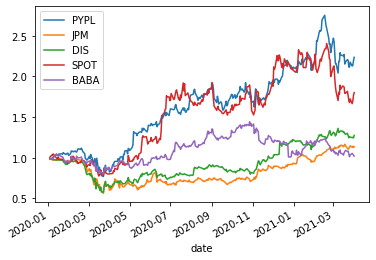

In [13]:
cum_returns.plot()

In [87]:
print(ptfPerformance(randomWeights(5), ptf))

(0.36186537368879684, 0.3438011737363175)
